In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Google Colab Setup 

Please run the code below to mount drive if you are running on colab.

Please ignore if you are running on your local machine.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive/MiniGPT/

# Language Modeling and Transformers

The project will consist of two broad parts. 

1. **Baseline Generative Language Model**: We will train a simple Bigram language model on the text data. We will use this model to generate a mini story. 
2. **Implementing Mini GPT**: We will implement a mini version of the GPT model layer by layer and attempt to train it on the text data. You will then load pretrained weights provided and generate a mini story. 

## Some general instructions 

1. Please keep the name of layers consistent with what is requested in the `model.py` file for each layer, this helps us test in each function independently. 
2. Please check to see if the bias is to be set to false or true for all linear layers (it is mentioned in the doc string)
3. As a general rule please read the docstring well, it contains information you will need to write the code. 
4. All configs are defined in `config.py` for the first part while you are writing the code do not change the values in the config file since we use them to test. Once you have passed all the tests please feel free to vary the parameter as you please.
5. You will need to fill in the `train.py` and run it to train the model. If you are running into memory issues please feel free to change the `batch_size` in the `config.py` file. If you are working on Colab please make sure to use the GPU runtime and feel free to copy over the training code to the notebook. 

In [4]:
# !pip install numpy torch tiktoken wandb einops # Install all required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import tiktoken

In [3]:
from model import BigramLanguageModel, SingleHeadAttention, MultiHeadAttention, FeedForwardLayer, LayerNorm, TransformerLayer, MiniGPT
from config import BigramConfig, MiniGPTConfig
import tests

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
path_to_bigram_tester = "./pretrained_models/bigram_tester.pt" # Load the bigram model with name bigram_tester.pt
path_to_gpt_tester = "./pretrained_models/minigpt_tester.pt" # Load the gpt model with name minigpt_tester.pt

##  Bigram Language Model (10 points)

A bigram language model is a type of probabilistic language model that predicts a word given the previous word in the sequence. The model is trained on a text corpus and learns the probability of a word given the previous word.



### Implement the Bigram model (5 points)

Please complete the `BigramLanguageModel` class in model.py. We will model a Bigram language model using a simple MLP with one hidden layer. The model will take in the previous word index and output the logits over the vocabulary for the next word.

In [6]:
# Test implementation for Bigram Language Model
model = BigramLanguageModel(BigramConfig)
tests.check_bigram(model,path_to_bigram_tester, device)

'TEST CASE PASSED!!!'

### Training the Bigram Language Model (2.5 points)

Complete the code in `train.py` to train the Bigram language model on the text data. Please provide plots for both the training and validation in the cell below.

Some notes on the training process:

1. You should be able to train the model slowly on your local machine.
2. Training it on Colab will help with speed.
3.  <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You should see it saturate to a value close to around 5-6 but as long as you see it decreasing then saturating you should be good.
4. Please log the loss curves either on wandb, tensorboard or any other logger of your choice and please attach them below.

### Train and Valid Plots

In [7]:
from train import *
model = BigramLanguageModel(BigramConfig)
run = train_model(model)

wandb: Currently logged in as: abaretta (andrea-projects). Use `wandb login --relogin` to force relogin


number of trainable parameters: 3.27M
Training iterations: 0/250000 - loss=10.824593544006348, val_loss=10.82491683959961
Training iterations: 25000/250000 - loss=4.82848596572876, val_loss=4.834754467010498
Training iterations: 50000/250000 - loss=4.9674787521362305, val_loss=4.036271095275879
Training iterations: 75000/250000 - loss=3.453408718109131, val_loss=4.029213905334473
Training iterations: 100000/250000 - loss=4.115808486938477, val_loss=4.50219202041626
Training iterations: 125000/250000 - loss=3.781562089920044, val_loss=4.8126091957092285
Training iterations: 150000/250000 - loss=4.477822303771973, val_loss=2.830197334289551
Training iterations: 175000/250000 - loss=3.684438705444336, val_loss=4.297950267791748
Training iterations: 200000/250000 - loss=3.9458887577056885, val_loss=4.31453275680542
Training iterations: 225000/250000 - loss=4.172185897827148, val_loss=4.262075424194336
Training iterations: 250000/250000 - loss=4.187849998474121, val_loss=4.149754524230957


train-loss,█▅▄▃▃▃▂▃▄▂▂▂▃▂▂▃▃▁▃▂▃▃▁▃▃▁▂▂▃▃▁▂▂▂▂▃▁▁▂▄
val-loss,█▄▄▃▃▂▂▂▂▃▃▂▃▁▂▁▂▁▁▃▂▂▂▂▁▃▁▂▂▂▃▂▂▁▂▁▂▂▃▁
train-loss,4.39077
val-loss,4.11462


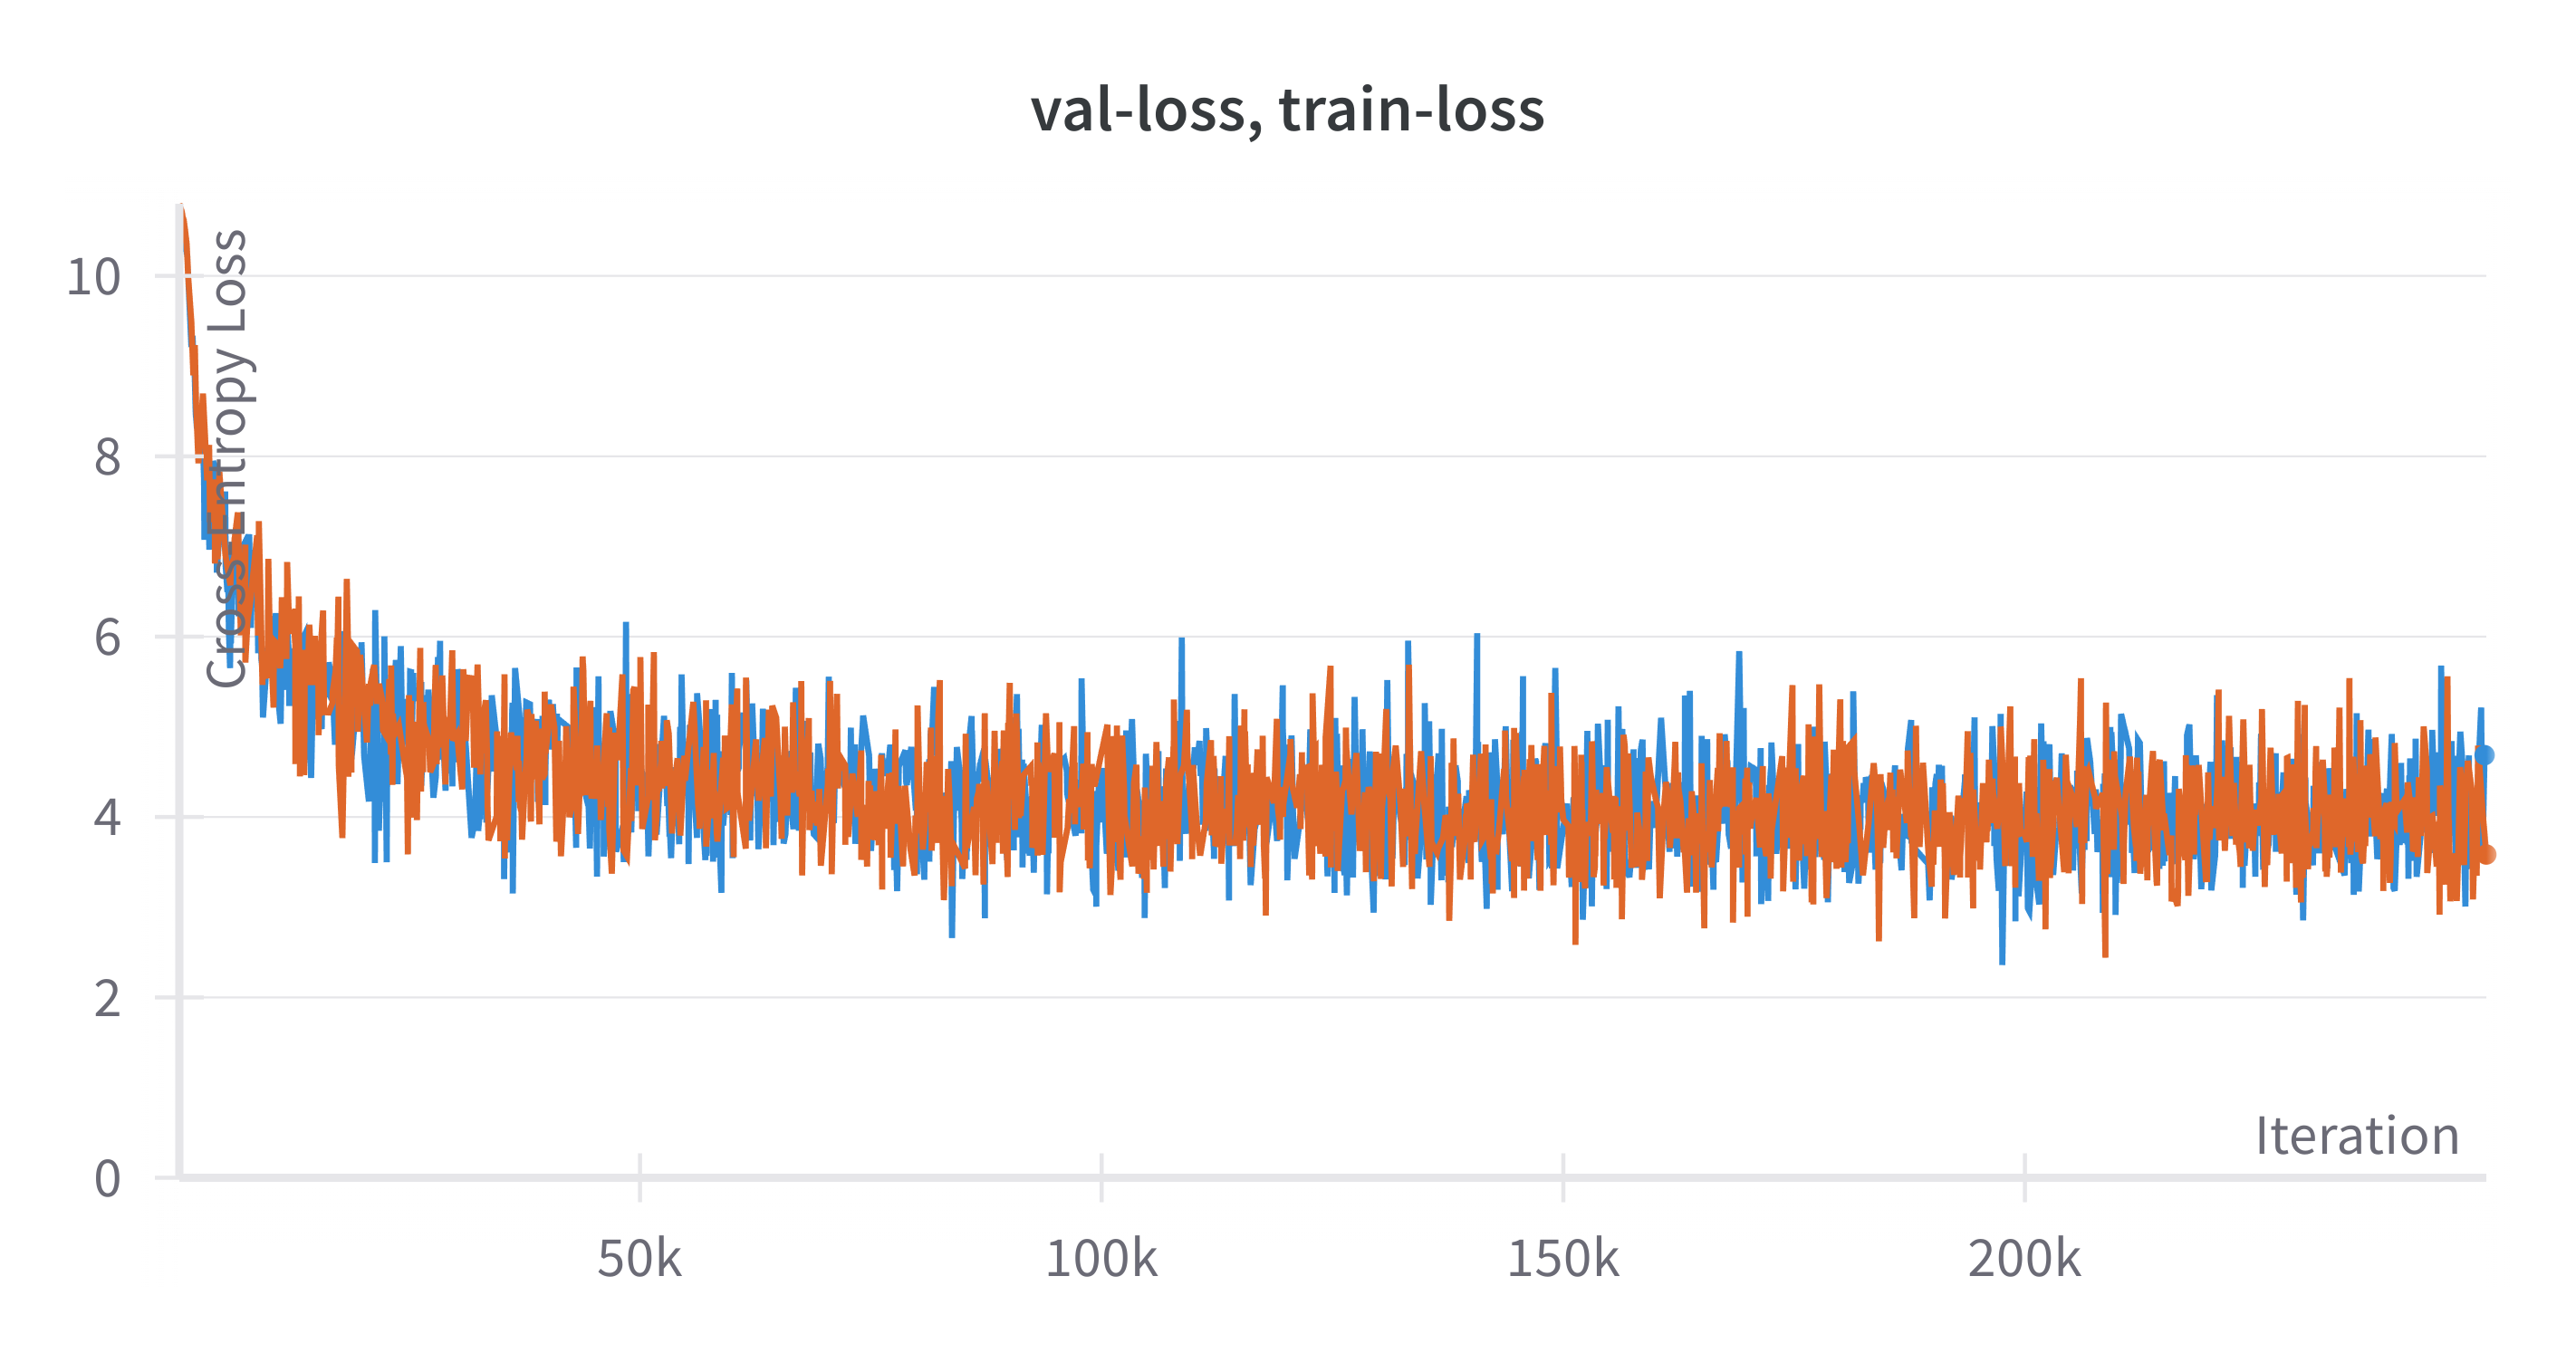

In [33]:
from IPython.display import Image
Image(filename='bigram.png') 

### Generation (2.5 points)

Complete the code in the `generate` method of the Bigram class and generate a mini story using the trained Bigram language model. The model will take in the previous word index and output the next word index.

Start with the following seed sentence: 
    
    `"once upon a time"`
    

In [9]:
tokenizer = tiktoken.get_encoding("gpt2")

In [14]:
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200)
    )
)

Generating text starting with: torch.Size([4])
, a time, "Let's not work with his family.
Varimming. He DGACT fair and
She sees pretty than herself. She said the sky. But then, "Can we do what else explan Truth. His bone.
Sam could always knocked on the little bird's nose. The girl named I can fix it was so he wanted to take explores nerds pulling node frantically extradition 166 Ender. She crawled main LoadingDallasickethots iT insultWorking. She wanted, she remembered that wanted to find a time, Lily told him.Once upon a little boy named Tomyo Cher Books WelshNav023 videog risksette academ. He saw somethingLGptiveJack and sharpofer neon 342 certain compliments effortlessly environments Designsathe if she had a small house is new boat Nig Moberydollarbilt hepatitisAccording says, Bob very much. Her mom. She looked at all looked at be brave when they were happy and thought named Tim got some sharp. Timmy too big swing too high in it was


### Observation and Analysis

Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence?

There is little of either, though occasionally once can observe splotches of something sensible, before being once again drowned out in what is largely nonsense.

2. What are the limitations of the Bigram language model?

They have virtually no context; they generate a new word from only the previous one. This means that any meaning and structure in a sentence is lost nearly right away.

3. If the model is scaled with more parameters do you expect the bigram model to get substantially better? Why or why not?

Likely not. As previously mentioned, the Bigram model fundamentally lacks nearly all contextual information when generating new tokens.

## Mini GPT (90 points)

We will not implement a decoder style transformer model like we discussed in lecture, which is a scaled down version of the [GPT model](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf). 

All the model components follow directly from the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. The only difference is we will use prenormalization and learnt positional embeddings instead of fixed ones. But you will not need to worry about these details!

We will now implement each layer step by step checking if it is implemented correctly in the process. We will finally put together all our layers to get a fully fledged GPT model. 

<span style="color:red">Later layers might depend on previous layers so please make sure to check the previous layers before moving on to the next one.</span>

### Single Head Causal Attention (20 points)

We will first implement the single head causal attention layer. This layer is the same as the scaled dot product attention layer but with a causal mask to prevent the model from looking into the future.

Recall that Each head has a Key, Query and Value Matrix and the scaled dot product attention is calculated as : 

\begin{equation}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\end{equation}

where $d_k$ is the dimension of the key matrix.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/Single_Head.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

In [37]:
model = SingleHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.embed_dim//4, MiniGPTConfig.embed_dim//4) # configs are set as such for testing do not modify
tests.check_singleheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

Please complete the `SingleHeadAttention` class in `model.py`

### Multi Head Attention (10 points)

Now that we have a single head working, we will now scale this across multiple heads, remember that with multihead attention we compute perform head number of parallel attention operations. We then concatenate the outputs of these parallel attention operations and project them back to the desired dimension using an output linear layer.

Figure below from the original paper shows how the layer is to be implemented.

![image](./Images/MultiHead.png)

Image credits: [Attention is All You Need Paper](https://arxiv.org/abs/1706.03762)

Please complete the `MultiHeadAttention` class in `model.py` using the `SingleHeadAttention` class implemented earlier. 

In [47]:
model = MultiHeadAttention(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)

tests.check_multiheadattention(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Feed Forward Layer (5 points)

As discussed in lecture, the attention layer is completely linear, in order to add some non-linearity we add a feed forward layer. The feed forward layer is a simple two layer MLP with a GeLU activation in between.

Please complete the `FeedForwardLayer` class in `model.py`

In [41]:
model = FeedForwardLayer(MiniGPTConfig.embed_dim)

tests.check_feedforward(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### LayerNorm (10 points)

We will now implement the layer normalization layer. Layernorm is used across the model to normalize the activations of the previous layer. Recall that the equation for layernorm is given as:

$$
\begin{equation}
\text{LayerNorm}(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \odot \gamma + \beta
\end{equation}
$$

With the learnable parameters $\gamma$ and $\beta$. 

Remember that unlike batchnorm we compute statistics across the feature dimension and not the batch dimension, hence we do not need to keep track of running averages.

Please complete the `LayerNorm` class in `model.py`

In [46]:
model = LayerNorm(MiniGPTConfig.embed_dim)
tests.check_layernorm(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Transformer Layer (15 points)

We have now implemented all the components of the transformer layer. We will now put it all together to create a transformer layer. The transformer layer consists of a multi head attention layer, a feed forward layer and two layer norm layers.

Please use the following order for each component (Varies slightly from the original attention paper):
1. LayerNorm
2. MultiHeadAttention
3. LayerNorm
4. FeedForwardLayer

Remember that the transformer layer also has residual connections around each sublayer.

The below figure shows the structure of the transformer layer you are required to implement.

![prenorm_transformer](./Images/Prenorm.png)

Image Credit : [CogView](https://arxiv.org/pdf/2105.13290)

Implement the `TransformerLayer` class in `model.py`

In [49]:
model =  TransformerLayer(MiniGPTConfig.embed_dim, MiniGPTConfig.num_heads)
tests.check_transformer(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Putting it all together : MiniGPT (15 points)

We are now ready to put all our layers together to build our own MiniGPT! 

The MiniGPT model consists of an embedding layer, a positional encoding layer and a stack of transformer layers. The output of the transformer layer is passed through a linear layer (called head) to get the final output logits. Note that in our implementation we will use [weight tying](https://arxiv.org/abs/1608.05859) between the embedding layer and the final linear layer. This allows us to save on parameters and also helps in training.

Implement the `MiniGPT` class in `model.py`

In [55]:
model = MiniGPT(MiniGPTConfig)
tests.check_miniGPT(model, path_to_gpt_tester, device)

'TEST CASE PASSED!!!'

### Attempt at training the model (5 points)

We will now attempt to train the model on the text data. We will use the same text data as before. Please scale down the model parameters in the config file to a smaller value to make training feasible. 

Use the same training script we built for the Bigram model to train the MiniGPT model. If you implemented it correctly it should work just out of the box!

**NOTE** : We will not be able to train the model to completion in this assignment. Unfortunately, without access to a relatively powerful GPU, training a large enough model to see good generation is not feasible. However, you should be able to see the loss decreasing over time. <span style="color:red">To get full points for this section it is sufficient to show that the loss is decreasing over time</span>. You do not need to run this for more than 5000 iterations or 1 hour of training.

In [6]:
from train import train_model
model = MiniGPT(MiniGPTConfig)
run = train_model(model)

wandb: Currently logged in as: abaretta (andrea-projects). Use `wandb login --relogin` to force relogin


number of trainable parameters: 1.67M
Training iterations: 0/5000 - loss=10.831780433654785, val_loss=10.83149528503418
Training iterations: 500/5000 - loss=6.242453098297119, val_loss=6.253159046173096
Training iterations: 1000/5000 - loss=5.903860092163086, val_loss=5.944811820983887
Training iterations: 1500/5000 - loss=5.454929351806641, val_loss=5.639881134033203
Training iterations: 2000/5000 - loss=4.995589733123779, val_loss=4.974545478820801
Training iterations: 2500/5000 - loss=4.568240165710449, val_loss=4.562541484832764
Training iterations: 3000/5000 - loss=4.375434875488281, val_loss=4.4109721183776855
Training iterations: 3500/5000 - loss=4.213255882263184, val_loss=4.19697904586792
Training iterations: 4000/5000 - loss=4.115374565124512, val_loss=4.055615425109863
Training iterations: 4500/5000 - loss=4.098515033721924, val_loss=3.942117929458618
Training iterations: 5000/5000 - loss=3.878499984741211, val_loss=3.923942804336548


train-loss,█▇▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val-loss,█▇▆▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train-loss,3.96239
val-loss,3.98392


### Train and Valid Plots


** Show the training and validation loss plots **

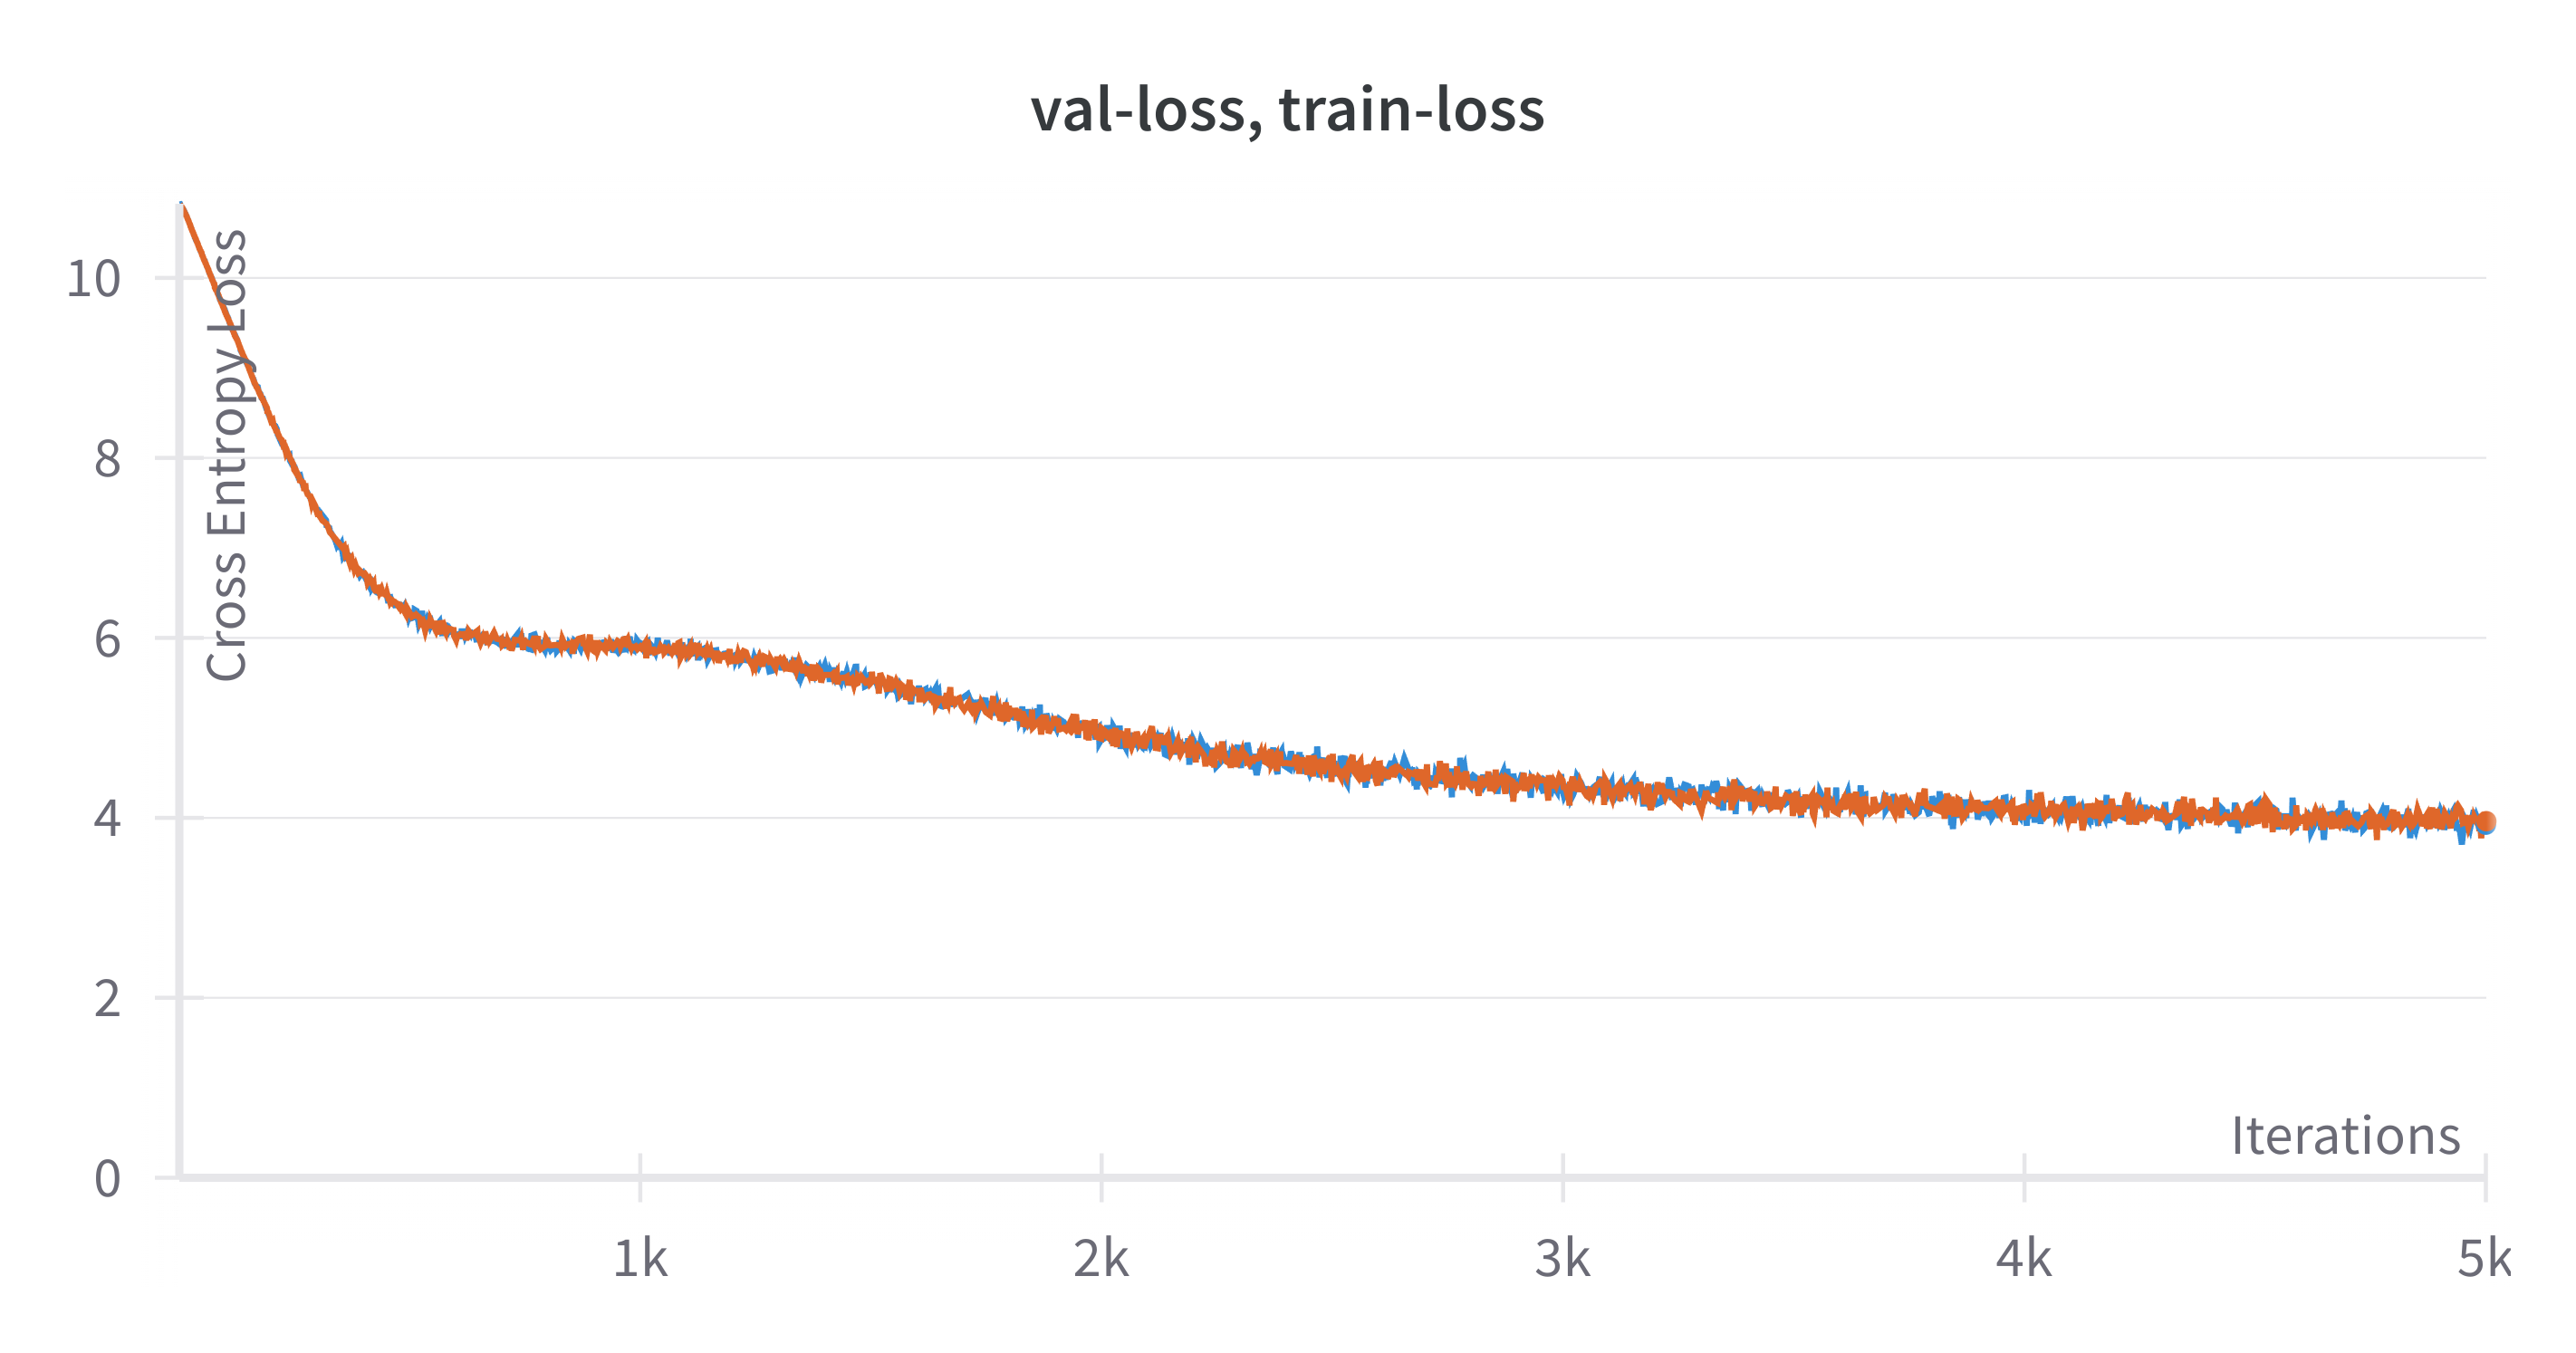

In [31]:
from IPython.display import Image
Image(filename='minigpt.png') 

### Generation (5 points)


Perform generation with the model that you trained. Copy over the generation function you used for the Bigram model not the `miniGPT` class and generate a mini story using the same seed sentence. 

    `"once upon a time"`

In [8]:
tokenizer = tiktoken.get_encoding("gpt2")

In [22]:
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a time. It.Once upon a there was a little while, there was a little girl named Lily, but sometimes we'll you get up across the sailor.Maybe it is it. The birthday thin cat were not hungry. Timmy told it out on yes and said. "Tom, you praising. The moral when we grateful for find it. 
She didn't won't know what found a world to Tim still gentle man outdoors, and number.
They wished he looked out a big tree and come in her, and the bag anyway. I were not listen putting it into the friends from the tree. He saw through her hands. He liquidity his toys, but daddy asked it and replied!"
But watching the squirrel. They water were very bright.
As Sue. The little dog watched her up and scream and Airport are a hot Pruitt Sara and the important, but heSingle their friends was happy and promised to try a little necklace in a kids and seek


Please answer the following questions. 

1. What can we say about the generated text in terms of grammar and coherence?

Despite possessing half the number of parameters of the Bigram model, this is much more understandable and coherent. Grammar is usually used, and sentences have mostly coherent structures.

2. If the model is scaled with more parameters do you expect the GPT model to get substantially better? Why or why not?

I would expect yes. With few parameters, it is already performing very well. More would certainly make it more powerful. Additionally, validation loss is exactly in line with training loss, suggesting that the model is far from overfitting.

### Scaling up the model (5 points)

To show that scale indeed will help the model learn we have trained a scaled up version of the model you just implemented. We will load the weights of this model and generate a mini story using the same seed sentence. Note that if you have implemented the model correctly just scaling the parameters and adding a few bells and whistles to the training script will results in a model like the one we will load now. 

In [23]:
from model import MiniGPT
from config import MiniGPTConfig

In [24]:
path_to_trained_model = "pretrained_models/best_train_loss_checkpoint.pth"

In [25]:
ckpt = torch.load(path_to_trained_model, map_location=device) # remove map location if using GPU

In [26]:
# Set the configs for scaled model 
MiniGPTConfig.context_length = 512
MiniGPTConfig.embed_dim = 256
MiniGPTConfig.num_heads = 16
MiniGPTConfig.num_layers = 8

In [27]:
# Load model from checkpoint
model = MiniGPT(MiniGPTConfig)
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [28]:
tokenizer = tiktoken.get_encoding("gpt2")

In [29]:
model.to(device)
gen_sent = "Once upon a time"
gen_tokens = torch.tensor(tokenizer.encode(gen_sent))
print("Generating text starting with:", gen_tokens.shape)
gen_tokens = gen_tokens.to(device)
model.eval()
print(
    tokenizer.decode(
        model.generate(gen_tokens, max_new_tokens=200).squeeze().tolist()
    )
)

Generating text starting with: torch.Size([4])
Once upon a time, there was a little ant named Andy. Andy was very small, but he had a sweet taste of everything he saw. One day, Andy saw a big spider web in the ground. The web was dark and spiky, but Andy was curious to see it up close. 
Andy went to his friend, a kind little bird named Lily. "Lily, I see a spider today!" Andy said. "Me too," Lily replied. "Let's go together and explore the world!" 
So, Andy and Lily walked through the garden and saw many pretty things. They saw ants and bugs, and even a big mushroom. They even saw some fish swimming in the water. 
Finally, they reached a beautiful flower that was just like Andy's favorite flavor. "Thank you, Lily!" Andy said. "No problem, Andy. I'm happy to make you happy." And kept walking, sharing his sweet taste of the yummy food he had making along the way


## Bonus (5 points)

The following are some open ended questions that you can attempt if you have time. Feel free to propose your own as well if you have an interesting idea. 

1. The model we have implemented is a decoder only model. Can you implement the encoder part as well? This should not be too hard to do since most of the layers are already implemented.
2. What are some improvements we can add to the training script to make training more efficient and faster? Can you concretely show that the improvements you made help in training the model better?
3. Can you implement a beam search decoder to generate the text instead of greedy decoding? Does this help in generating better text?
4. Can you further optimize the model architecture? For example, can you implement [Multi Query Attention](https://arxiv.org/abs/1911.02150) or [Grouped Query Attention](https://arxiv.org/pdf/2305.13245) to improve the model performance?